In [6]:
"""\
# Copyright (C) 2024 Jesús Bautista Villar <jesbauti20@gmail.com>
"""
!python3 -V || python -V

Python 3.10.12


In [4]:
import numpy as np
import os
import sys
from tqdm import tqdm

# Graphic tools
import matplotlib.pyplot as plt

# Animation tools
from IPython.display import HTML
from matplotlib.animation import PillowWriter

# --------------------------------------------------------------------------------------

# Swarm Systems Lab PySimUtils
from ssl_pysimutils import createDir, uniform_distrib, gen_Z_random, R_2D_matrix

# Python project directory to path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import simulators, plots and animations
from dfc import Simulator, SimulatorDistr
from dfc.plots import plot_centralized, plot_distributed, plot_resilience
from dfc.plots import plot_distributed_small, plot_resilience_small
from dfc.animations import AnimBasic
# --------------------------------------------------------------------------------------

# Output directory
OUTPUT_PATH = os.path.join("..", "output")

createDir(OUTPUT_PATH)

The directory '../output' already exists!


## Centralized simulation

In [2]:
# Generate the robots distribution and set the initial positions
N = 70
lims = [1, 2]
rc0 = [0, 0]

p0 = uniform_distrib(N=N, lims=lims, rc0=rc0, seed=2024)

# Generating the simulator class
dt = 0.01
lambda_d = [10, 5]
ke = 0.2

sim = Simulator(p0=p0, dt=dt, lambda_d=lambda_d, ke=ke)

# ----------------------------------------------------------------------
# Execute the simulation given a desired final time stamp
# ----------------------------------------------------------------------
tf = 2.5

t_list = np.arange(0, tf, dt)
for it in tqdm(range(len(t_list))):
    sim.int_euler()

  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [00:00<00:00, 7076.70it/s]


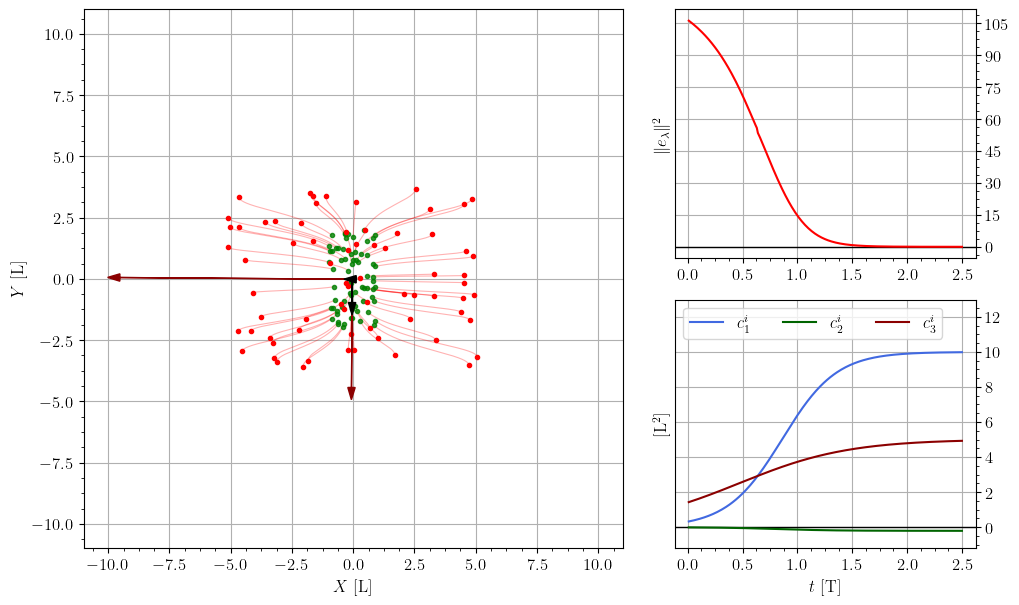

In [20]:
plot_centralized(sim, lim=11, dpi=100, figsize=(12,7))

In [ ]:
animator = AnimBasic(sim, lim=11, agent_r=0.1, tail_alpha=0.7)

# -- MP4 
anim = animator.gen_animation()
HTML(anim.to_html5_video()) # It takes a loooot of time...

# -- GIF
# writer = PillowWriter(fps=15, bitrate=1800)
# anim.save(os.path.join(OUTPUT_FOLDER, "test.gif"),
#         writer = writer)

## Distributed simulation

In [42]:
# Generate the robots distribution and set the initial positions
N = 70
lims = [2, 2]
rc0 = [0, 1]

p0 = uniform_distrib(N=N, lims=lims, rc0=rc0, seed=2024)

# Generate the graph
Z = gen_Z_random(N, rounds=3, seed=2024)

# Generating the simulator class
dt = 0.01
lambda_d = [10, 4]
ke = 0.2

sim = SimulatorDistr(p0=p0, Z=Z, dt=dt, lambda_d=lambda_d, 
                     ke=ke, kpc=1, its_pc=8, kc=1, its_c=8)

# Graph connectivity (lambda2)
print(r"$\lambda_2$:", sim.lambda_min)

$\lambda_2$: 0.7040709772438613


In [43]:
# ----------------------------------------------------------------------
# Execute the simulation given a desired final time stamp
# ----------------------------------------------------------------------
tf = 2.5

t_list = np.arange(0, tf, dt)
for it in tqdm(range(len(t_list))):
    sim.int_euler()

100%|██████████| 250/250 [00:05<00:00, 47.07it/s]


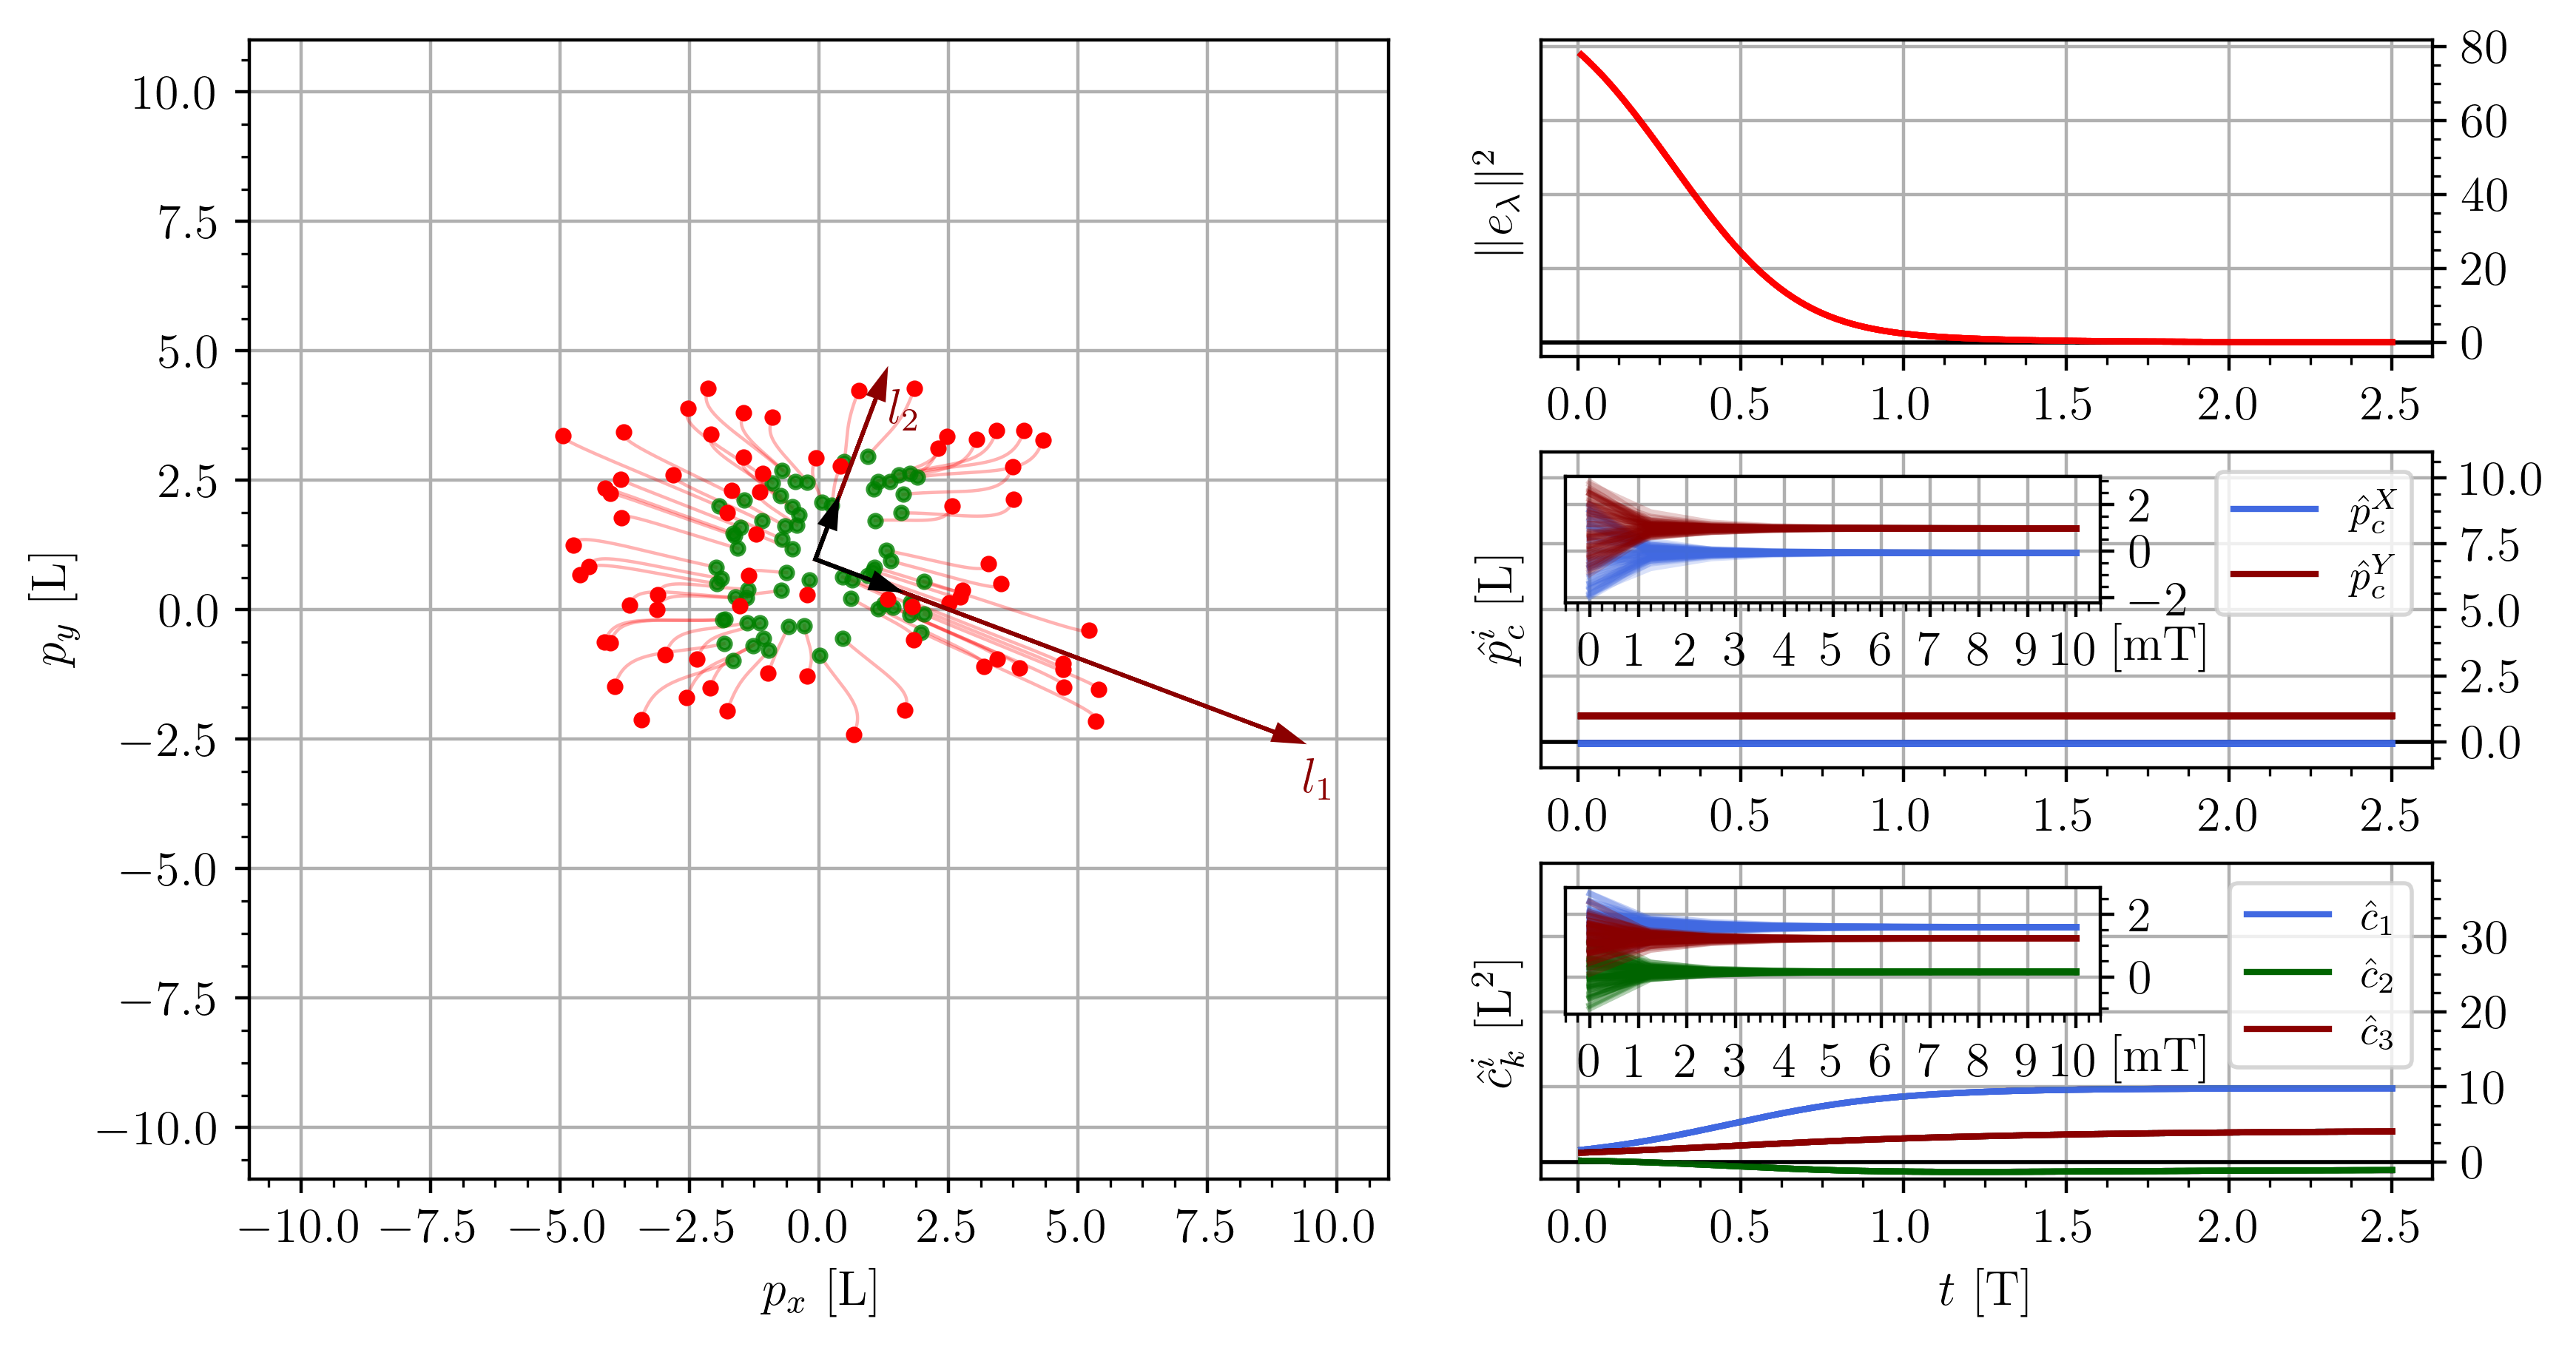

In [44]:
plot_distributed(sim, lim=11, dpi=400, figsize=(10,5))
# plot_distributed_small(sim, lim=11, dpi=400, figsize=(10,5))

In [18]:
animator = AnimBasic(sim, lim=7.5, agent_r=0.1, tail_alpha=0.7)

# -- MP4 
anim = animator.gen_animation()
HTML(anim.to_html5_video()) # It takes a loooot of time...

# -- GIF
# writer = PillowWriter(fps=15, bitrate=1800)
# anim.save(os.path.join(OUTPUT_FOLDER, "test.gif"),
#         writer = writer)

Simulating 249 frames... 
Progress:


100%|██████████| 249/249 [00:30<00:00,  6.33it/s]

## Resilience simulation

In [26]:
# Generate the robots distribution and set the initial positions
N = 70
lims = [2, 2]
rc0 = [0, 0]

p0 = uniform_distrib(N=N, lims=lims, rc0=rc0)

# Generating the simulator class
dt = 0.01
lambda_d = [10, 5]
ke = 0.2

sim = Simulator(p0=p0, dt=dt, lambda_d=lambda_d, ke=ke)

# ----------------------------------------------------------------------
# Execute the simulation given a desired final time stamp
# ----------------------------------------------------------------------
tf = 10

R1 = R_2D_matrix(np.pi/3*dt)
R2 = R_2D_matrix(np.pi/2*dt)
R3 = R_2D_matrix(np.pi/4*dt)
R4 = R_2D_matrix(np.pi*dt)
sim.active[N-4:N] = 0

t_list = np.arange(0, tf, dt)
for it in tqdm(range(len(t_list))):
    sim.variables["p"][-1] = (R1 @ sim.variables["p"][-1][:,None]).squeeze()
    sim.variables["p"][-2] = (R2 @ sim.variables["p"][-2][:,None]).squeeze()
    sim.variables["p"][-3] = (R3 @ sim.variables["p"][-3][:,None]).squeeze()
    sim.variables["p"][-4] = (R4 @ sim.variables["p"][-4][:,None]).squeeze()
    sim.int_euler()

100%|██████████| 1000/1000 [00:00<00:00, 6479.58it/s]


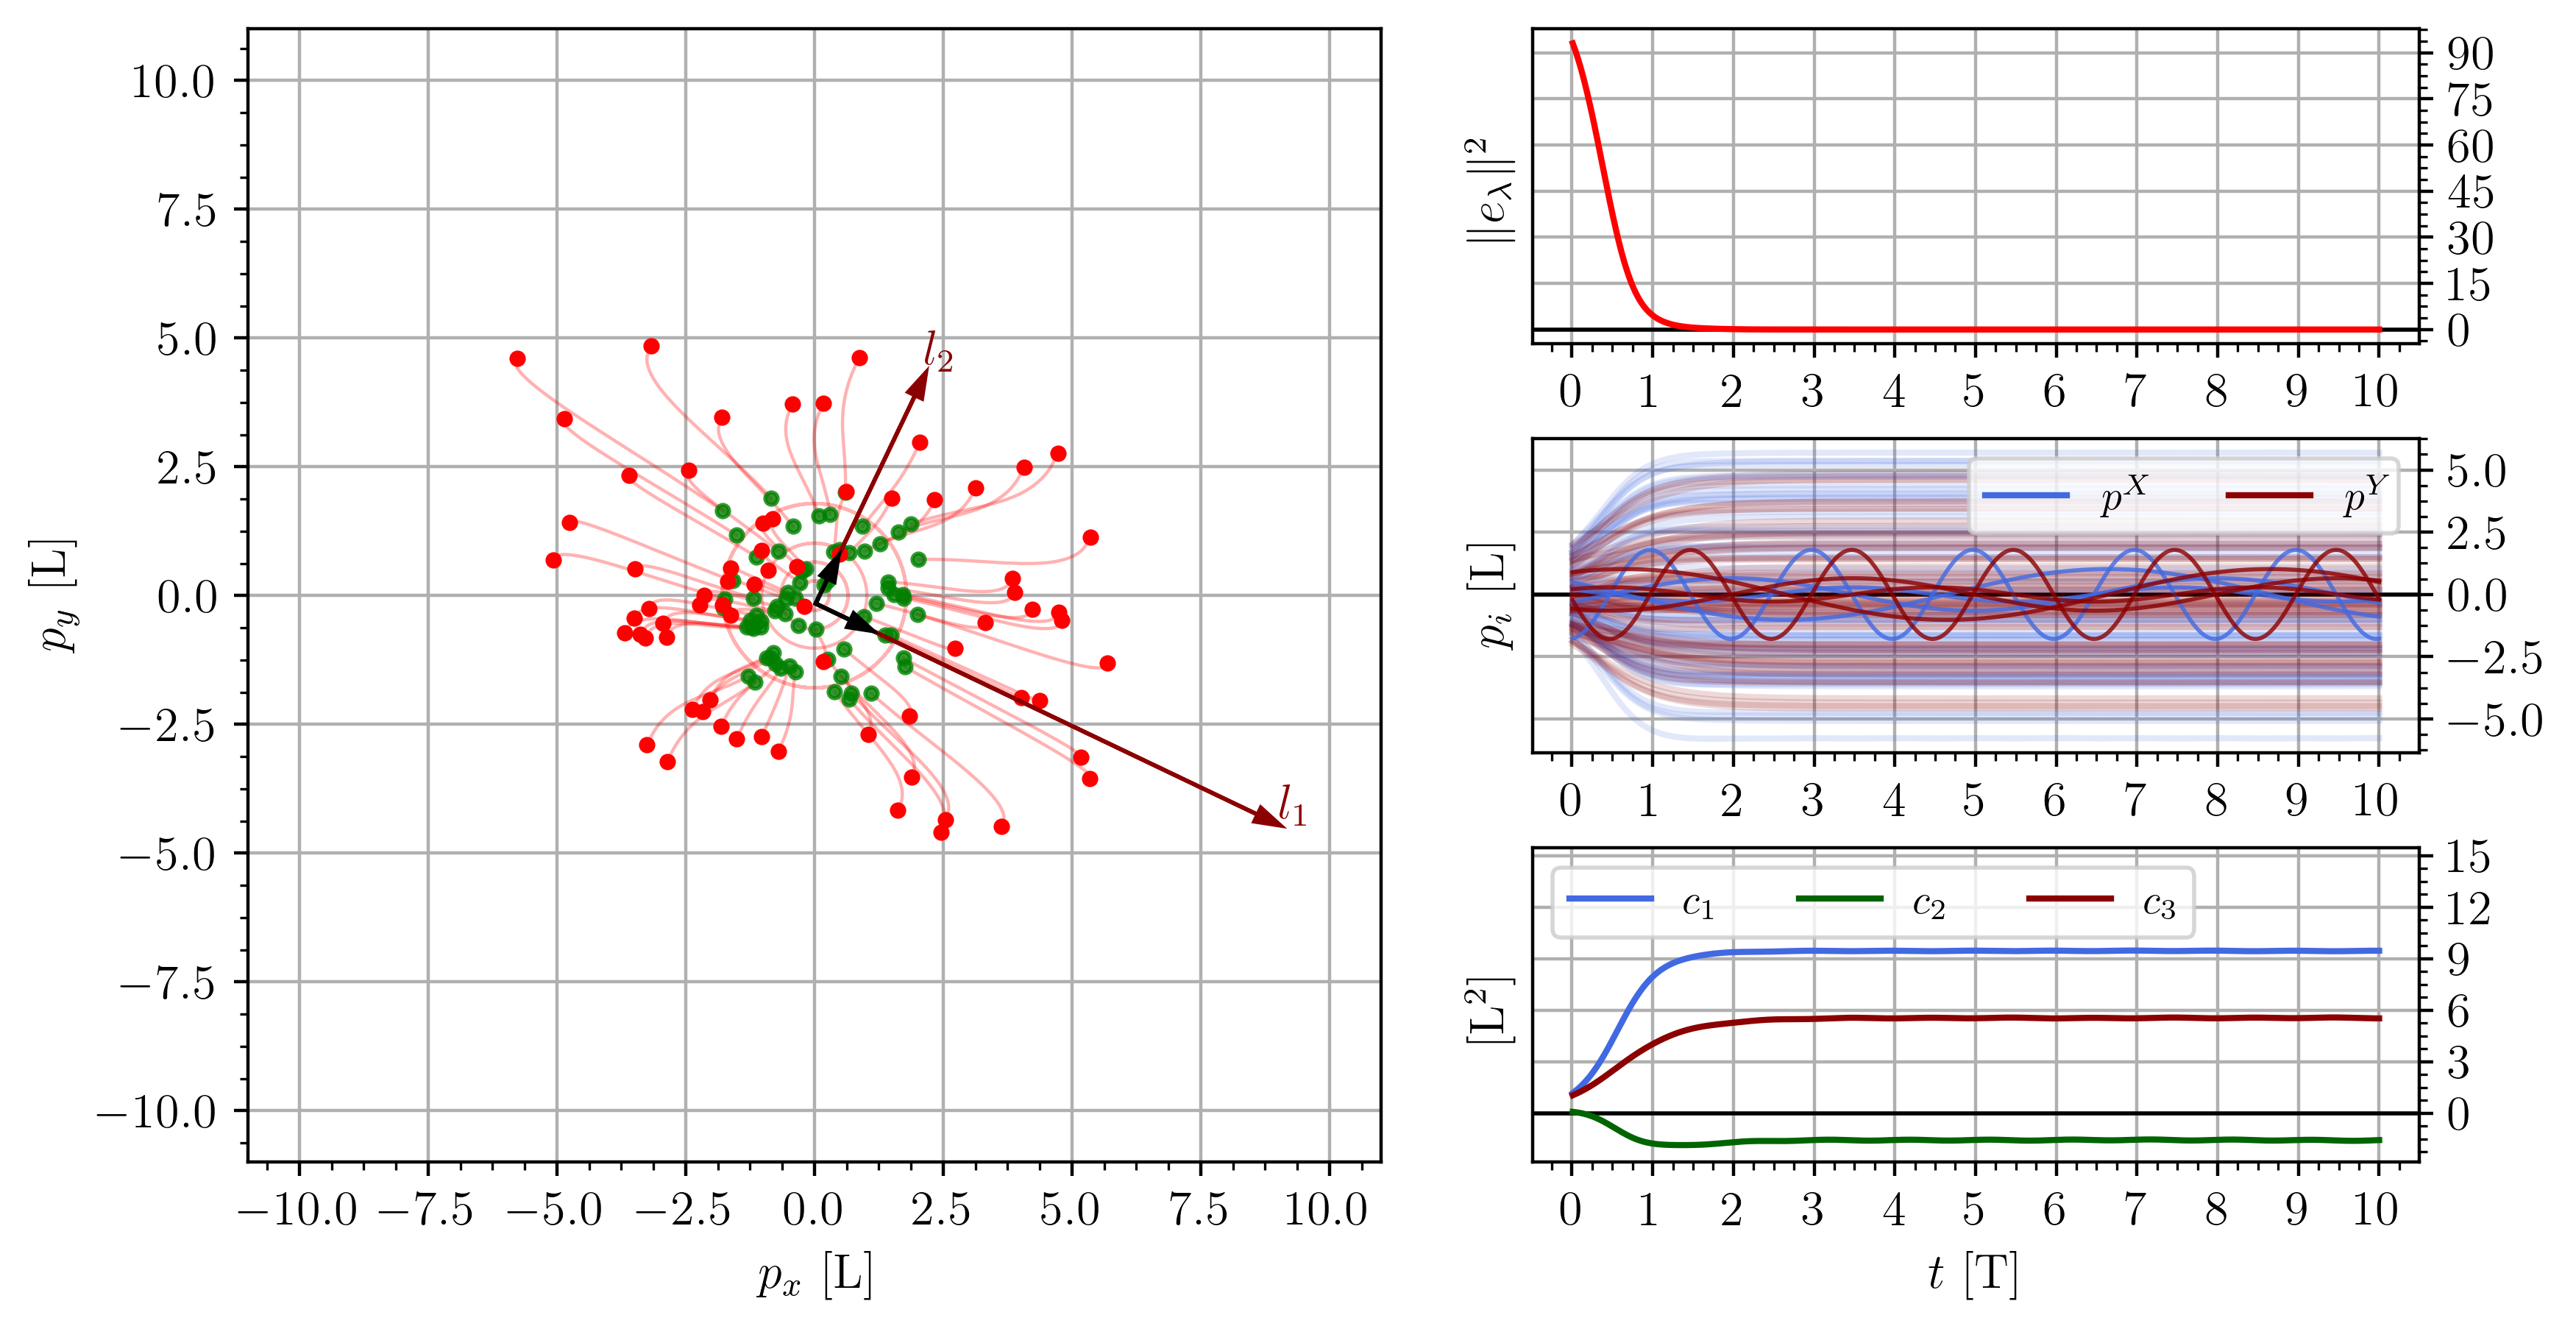

In [27]:
plot_resilience(sim, lim=11, dpi=400, figsize=(10,5), t_sep=1)
# plot_resilience_small(sim, lim=11, dpi=400, figsize=(10,5), t_sep=1)

In [6]:
animator = AnimBasic(sim, lim=7.5, agent_r=0.1, tail_alpha=0.7)

# -- MP4 
anim = animator.gen_animation()
HTML(anim.to_html5_video()) # It takes a loooot of time...

# -- GIF
# writer = PillowWriter(fps=15, bitrate=1800)
# anim.save(os.path.join(OUTPUT_FOLDER, "test.gif"),
#         writer = writer)

Simulating 999 frames... 
Progress:


100%|██████████| 999/999 [10:33<00:00,  1.87it/s]